In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sma

import seaborn as sns
from __future__ import division

sns.set(style="whitegrid", color_codes=True)

plt.style.use('seaborn-whitegrid')

pd.options.display.max_columns = 50

np.random.seed(42)

%matplotlib inline

## Generate Time Series

In [2]:
date_index = pd.date_range('2010-1-1', '2015-12-31', freq='W-MON')
periods = len(date_index)
print periods

313


In [164]:
X_returns = np.random.normal(0, 1, periods) 
# sum them and shift all the prices up into a reasonable range
X = pd.Series(np.cumsum(X_returns), name='X0', index=date_index) + 50

In [6]:
data_gen = pd.DataFrame(X)

In [10]:
some_noise = np.random.normal(0, 1, days)
Y = X + 5 + some_noise
Y.name = 'X1'
data = pd.concat([data_gen, Y], axis=1)
source_col = 'X1'

## Brownian Motion

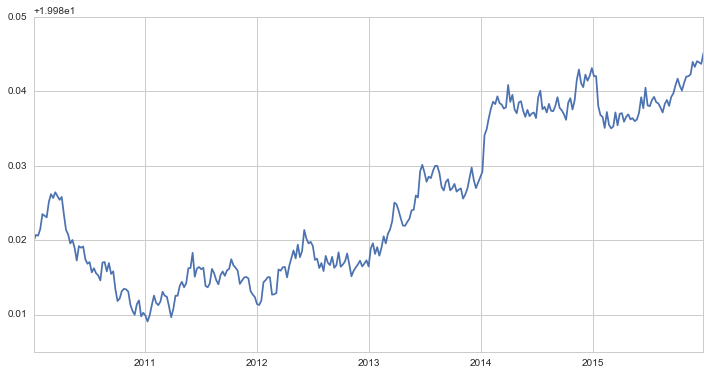

In [3]:
DAYS_PER_YEAR = 252.0
source_col = 'X1'

def brownian_motion(periods, start_price, mu, sigma, delta):
    t = delta / DAYS_PER_YEAR
    prices = np.zeros(periods)
    epsilon_sigma_t = np.random.normal(0, 1, periods) * sigma * np.sqrt(t)
    prices[0] = start_price
    for i in range(1, len(prices)):
        prices[i] = prices[i-1] * mu * t + \
                    prices[i-1] * epsilon_sigma_t[i-1] + \
                    prices[i-1]
    return prices

T = 2
mu = 0.1
sigma = 0.01
S0 = 20
dt = 0.01


p = brownian_motion(periods, S0, mu, sigma, dt)
data = pd.DataFrame(p, columns=[source_col], index=date_index)
plt.figure(figsize=(12,6))
plt.plot(data)
plt.show()

## Better Yet: Get Actual Time Series

In [46]:
import Quandl
data = Quandl.get("YAHOO/INDEX_GSPC", authtoken="6eVZpvq3zGzGsbaNsdDN", 
                  collapse='monthly', 
                  trim_start='1990-01-01',
                  trim_end='2016-01-31')

In [47]:
print data.columns
source_col = 'Adj Close'

Index([u'Open', u'High', u'Low', u'Close', u'Volume', u'Adj Close'], dtype='object')


## Plot Source Data

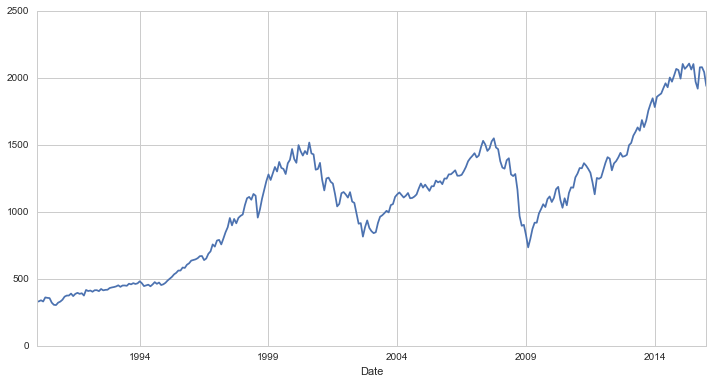

In [48]:
data[source_col].plot(figsize=(12,6))

## Moving Average

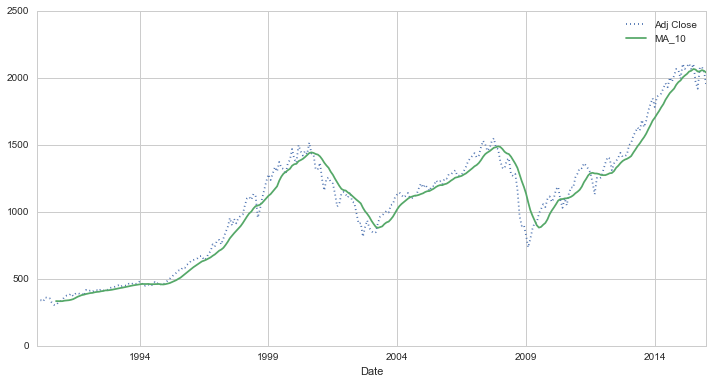

In [49]:
window = 10
ma_col = 'MA_{0}'.format(window)
data[ma_col] = pd.rolling_mean(data[source_col], window)
data[[source_col, ma_col]].plot(figsize=(12,6), style=[':', '-'])


## Deltas, Log Delta, Variance

In [50]:
data['log'] = data[source_col].apply(lambda x: np.log(x))
data['delta'] = data[source_col].diff()
data['log_delta'] = data['log'].diff()

data['var'] = pd.rolling_var(data[source_col], window, min_periods=None, freq=None, center=True)  
data['log_var'] = pd.rolling_var(data['log'], window, min_periods=None, freq=None, center=True)

data['std'] = pd.rolling_std(data[source_col], window, min_periods=None, freq=None, center=True)  
data['log_std'] = pd.rolling_std(data['log'], window, min_periods=None, freq=None, center=True)

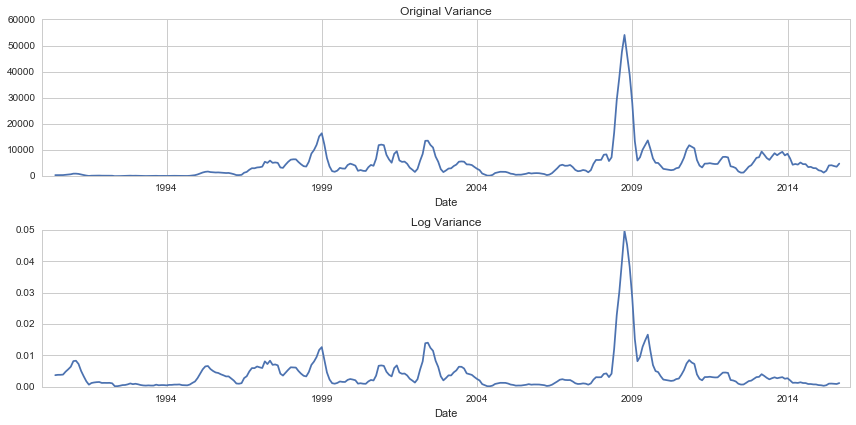

In [51]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))  
data['var'].plot(ax=ax[0], title='Original Variance')  
data['log_var'].plot(ax=ax[1], title='Log Variance')  
# data['std'].plot(ax=ax[2], title='Original Stdev')  
# data['log_std'].plot(ax=ax[3], title='Log Stdev')  
fig.tight_layout()  

## Lags

In [52]:
N = [1,4,13,26,40,53]

for n in N:
    data['lag_{0}'.format(n)] = data['log_delta'].shift(n)

In [53]:
print len(data['log_delta'].dropna())
print len(data['log_delta'])


312
313


In [54]:
def r2(x,y):
    r, p = sp.stats.pearsonr(x, y)
    return r**2, p

r, p = sp.stats.pearsonr(data['log_delta'].fillna(data['log_delta'].median()), 
                         data['lag_1'].fillna(data['lag_1'].median()))
print r, p
print r2(data['log_delta'].fillna(data['log_delta'].median()), 
                         data['lag_1'].fillna(data['lag_1'].median()))



0.0550724519104 0.331463581006
(0.003032974959423129, 0.33146358100562312)


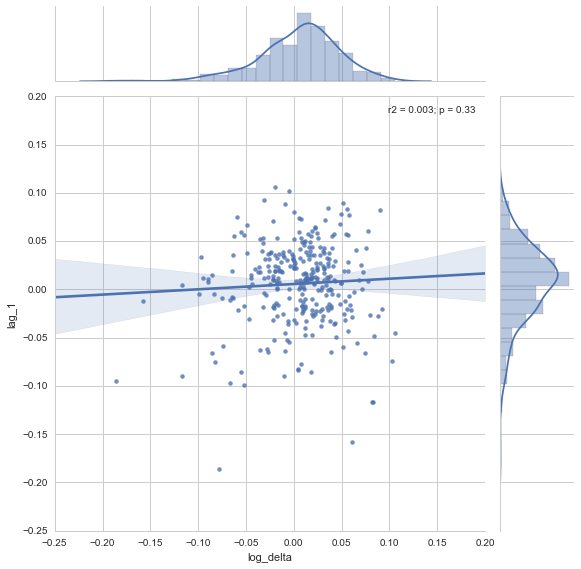

In [55]:
# for n in N:
n = 1
sns.jointplot('log_delta', 'lag_{0}'.format(n), data, kind='reg', stat_func=r2, size=8, ratio=5)

## Auto-correlations

In [56]:
lag_correlations = sma.tsa.stattools.acf(data['log_delta'].iloc[1:], nlags=40)  
lag_partial_correlations = sma.tsa.stattools.pacf(data['log_delta'].iloc[1:], nlags=40)  

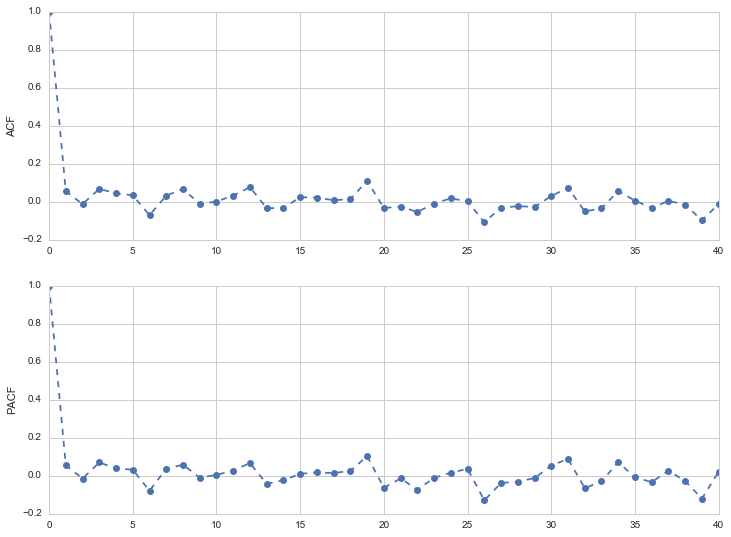

In [57]:
plt.subplots(figsize=(12, 9))  
plt.subplot(2,1,1)
plt.plot(lag_correlations, marker='o', linestyle='--')
plt.ylabel('ACF')

plt.subplot(2,1,2)
plt.plot(lag_partial_correlations, marker='o', linestyle='--')  
plt.ylabel('PACF')

## Hodrick-Prescott filter

129600


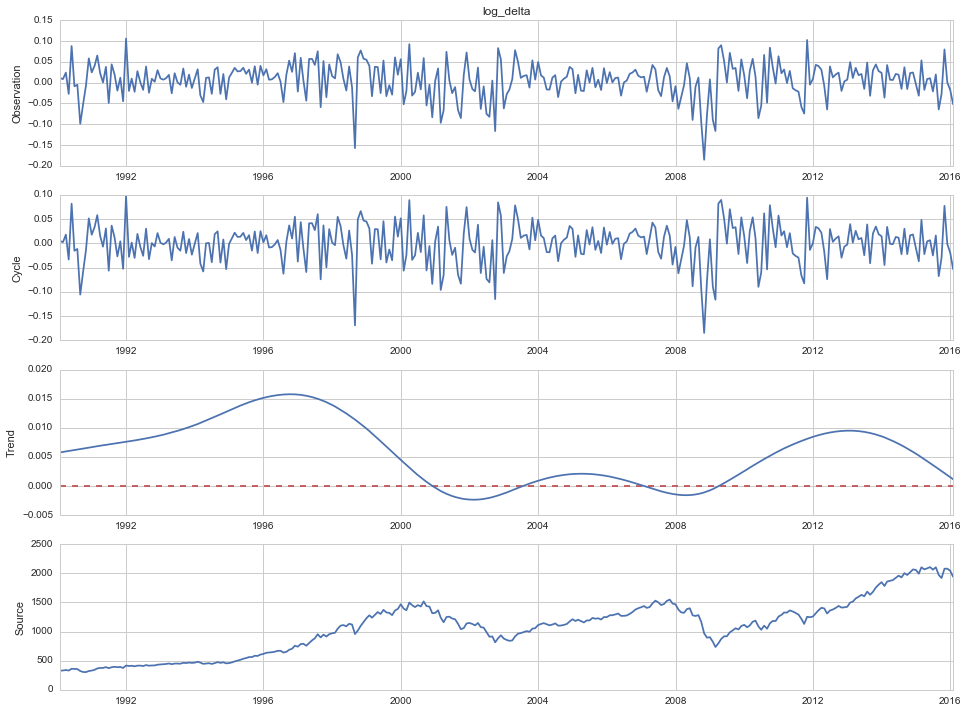

In [58]:
# col = 'Adjusted Close'
col = 'log_delta'
dt = data[col].fillna(data[col].median())#.as_matrix()

# from: http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.filters.hp_filter.hpfilter.html
# The Hodrick-Prescott smoothing parameter. 
# A value of 1600 is suggested for quarterly data. 
# Ravn and Uhlig suggest using a value of 6.25 (1600/4**4) for annual data 
# and 129600 (1600*3**4) for monthly data.
l = (1600*3**4)
print l
cycle, trend = sma.tsa.filters.hpfilter(dt, l)
# print len(cycle), len(trend)
# print cycle
decomp = pd.DataFrame(dt, columns=[col])
decomp["cycle"] = cycle
decomp["trend"] = trend

fig = plt.figure()  

plt.subplots(figsize=(16, 12))  

plt.subplot(4,1,1, title=col)
plt.plot(decomp[col])
plt.ylabel('Observation')

plt.subplot(4,1,2)
plt.plot(decomp.cycle)
plt.ylabel('Cycle')

plt.subplot(4,1,3)
plt.plot(decomp.trend)
plt.hlines(0, decomp.index.min(), decomp.index.max(), colors='r', linestyles='dashed')
plt.ylabel('Trend')

plt.subplot(4,1,4)
plt.plot(data[source_col])
plt.ylabel('Source')

plt.show()

## ARIMA

2016-01-31 00:00:00


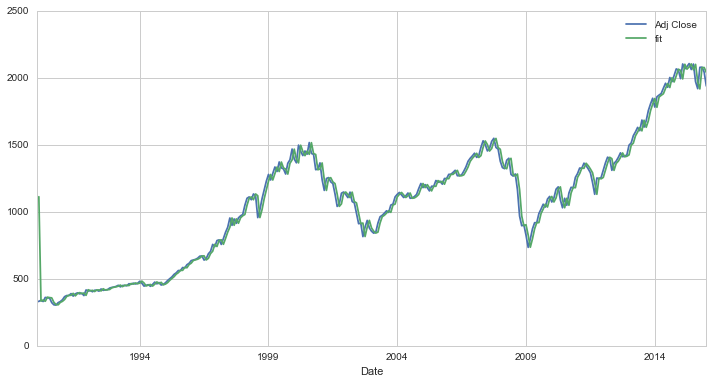

In [63]:
col = 'Adj Close'
print data.index.max()
model = sma.tsa.ARIMA(data[col].iloc[1:], order=(1, 0, 0))  
results = model.fit(disp=-1)  
data['fit'] = results.fittedvalues  
# data['forecast'] = results.predict(start='2015-11-30', end='2016-01-31', dynamic=True)  
data[[col, 'fit']].plot(figsize=(12, 6))  

## Exponential Smoothing

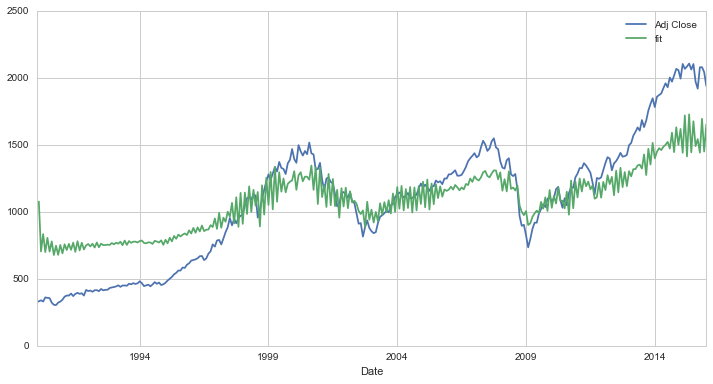

In [62]:
col = 'Adj Close'
model = sma.tsa.ARIMA(data[col].iloc[1:], order=(0, 0, 1))  
results = model.fit()  
data['fit'] = results.fittedvalues  
# data['forecast'] = results.predict(start='2015-11-30', end='2016-01-31', dynamic=True)  
data[[col, 'fit']].plot(figsize=(12, 6))

In [47]:
results.forecast(steps=10)

(array([ 0.0015636 ,  0.00163504,  0.00163504,  0.00163504,  0.00163504,
         0.00163504,  0.00163504,  0.00163504,  0.00163504,  0.00163504]),
 array([ 0.02636206,  0.02636426,  0.02636426,  0.02636426,  0.02636426,
         0.02636426,  0.02636426,  0.02636426,  0.02636426,  0.02636426]),
 array([[-0.05010509,  0.05323228],
        [-0.05003796,  0.05330804],
        [-0.05003796,  0.05330804],
        [-0.05003796,  0.05330804],
        [-0.05003796,  0.05330804],
        [-0.05003796,  0.05330804],
        [-0.05003796,  0.05330804],
        [-0.05003796,  0.05330804],
        [-0.05003796,  0.05330804],
        [-0.05003796,  0.05330804]]))